# 3. Scene inspection

## Overview

This tutorial explores an important mechanism in Mitsuba 2 that will let you inspect and modify scenes and other Mitsuba objects: `traverse()`

This mechanism recursively traverses a Mitsuba object and its children and returns a dictionary-like object that can be used to read and write associated object parameters. This will be your main entry point for things like scene editting and is therefore useful for a variaty of applications. Updates to those parameters will then propagate back through the dependency graph, and perform all necessary updates to the parent objects. For instance, a change to the vertex position buffer of a mesh in the scene will trigger the recomputation of the Embree/Optix BHV.

As we will see in later tutorials, `traverse()` is a key mechanism in the realm of inverse rendering applications when using the Mitsuba framework.

More specifically, in this tutorial you will learn how to access scene parameters and do minor edits like changing the color of light sources before re-rendering.

<div class="alert alert-block alert-info">

✔️ **What will you learn?**
    
<ul>
  <li>Use the traverse mechanism to inspect a scene graph</li>
  <li>Edit some scene parameters and propagate update</li>
  <li>Convert Bitmap images to numpy array</li>
</ul>
    
</div>


### Step 1 - set things up

Following the same steps as in [Tutorial 1](01_first_render), let's import `mitsuba` and load a scene from an XML file on disk.

In [1]:
# Add mitsuba and enoki to PATH (this shouldn't be necessary)
import sys
sys.path.append('/home/speierers/projects/mitsuba2-symbolic/build/python')

In [2]:
import enoki as ek 
import mitsuba
mitsuba.set_variant('scalar_rgb')

from mitsuba.core.xml import load_file
scene = load_file('../scenes/simple.xml')

2021-04-23 13:38:04 INFO main [xml.cpp:1239] Loading XML file "../scenes/simple.xml" ..

2021-04-23 13:38:04 INFO main [xml.cpp:1240] Using variant "scalar_rgb"

2021-04-23 13:38:04 INFO main [Scene] Embree ready. (took 20ms)

### Step 2 - access the scene 

The `traverse` function takes any Mitsuba object as input and returns a `SceneParameters` object, with a similar API to `dict`. `SceneParameters` object can be printed in order to look at the keys of the various parameters available in our scene graph.

In [3]:
from mitsuba.python.util import traverse
params = traverse(scene)
print(f'params: {params}')

params: SceneParameters[
    sensor.near_clip,
    sensor.far_clip,
    sensor.focus_distance,
    sensor.shutter_open,
    sensor.shutter_open_time,
    sensor.x_fov,
    teapot.to_world,
    teapot.bsdf.reflectance.value,
    teapot.vertex_count,
    teapot.face_count,
    teapot.faces,
    teapot.vertex_positions,
    teapot.vertex_normals,
    teapot.vertex_texcoords,
    light1.intensity.value,
    light2.intensity.value,
]


As you can see, the first level of our scene graph is composed of 4 objects: `sensor`, `teapot`, `light1`, `light2`. Moreover, some of those objects points to nested child objects, like `teapot.bsdf`. The names of the objects in the scene graph are defined by the `id` of those objects. Please refer to the [XML scene format](...) documentation to see how to define those in the XML scene file.

Individual scene parameters can be accessed with the `__getitem__` operator, providing the `key` corresponding to the parameter. Let's read the values of a few of the scene parameters.

In [4]:
print('sensor.near_clip:             ',  params['sensor.near_clip'])
print('teapot.bsdf.reflectance.value:',  params['teapot.bsdf.reflectance.value'])
print('light1.intensity.value:       ',  params['light1.intensity.value'])

sensor.near_clip:              0.009999999776482582
teapot.bsdf.reflectance.value: [0.8999999761581421, 0.8999999761581421, 0.0]
light1.intensity.value:        [100.0, 100.0, 100.0]


Before making any modifications to the scene, let's render the scene as it is.

In [5]:
from mitsuba.python.util import render
image1 = render(scene)

2021-04-23 13:38:04 INFO main [SamplingIntegrator] Starting render job (256x256, 256 samples, 32 threads)

2021-04-23 13:38:05 INFO main [SamplingIntegrator] Rendering finished. (took 250ms)

### Step 3 - edit the scene

We are now going to make edits to the some of the scene parameters and re-render the scene. 

For the sake of this tutorial, let's simply tint the color of both light sources (`PointLight` and `PointLight_1`). Similar to a python `dict`, parameters can be modified in-place using the `__setitem__` operator. Internally, the `SceneParameters` object will record every updates in order to properly propagate those to parent objects. Once all updates were performed, is is necessary to call `SceneParameters.update` method to propagate the set of changes through the scene graph.

In [6]:
# Give a red tint to light1 and a green tint to light2
params['light1.intensity.value'] *= [1.5, 0.2, 0.2]
params['light2.intensity.value'] *= [0.2, 1.5, 0.2]

# Notify the scene of the changes
params.update()

# Render the modified scene
image2 = render(scene)

2021-04-23 13:38:05 INFO main [SamplingIntegrator] Starting render job (256x256, 256 samples, 32 threads)

2021-04-23 13:38:05 INFO main [SamplingIntegrator] Rendering finished. (took 253ms)

### Step 4 - display the images

The `Bitmap` class implements the Python buffer protocol and it is therefore possible to seemlessly convert it to numpy arrays. This can be useful for instance if ones want to use it along other Python frameworks like `matplotlib`. 

Let's create numpy arrays from our two images, specifying `copy=False` to make sure the data isn't copied.

In [7]:
import numpy as np
image1_np = np.array(image1, copy=False)
image2_np = np.array(image2, copy=False)

We can now easily display the render images using matplotlib without having to write the images to disk.

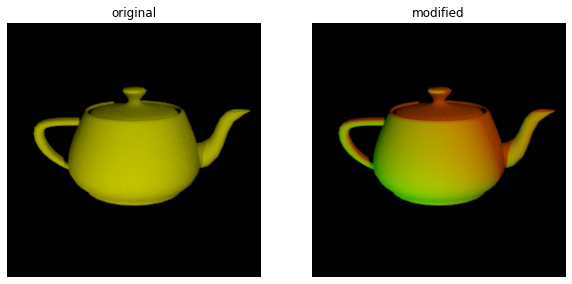

In [8]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1,2,1).imshow(image1_np); plt.axis('off'); plt.title('original')
fig.add_subplot(1,2,2).imshow(image2_np); plt.axis('off'); plt.title('modified');

### *Reference API*

- [<code>mitsuba.python.util.traverse</code>](...)
- [<code>mitsuba.python.util.render</code>](...)
- [<code>mitsuba.python.util.SceneParameters.update</code>](...)